In [63]:
%matplotlib ipympl

In [64]:
from impedance.models.circuits import CustomCircuit
from impedance.models.circuits.elements import element
import numpy as np
import scipy
from impedance.visualization import plot_nyquist
import matplotlib.pyplot as plt


In [65]:
def find_index_of_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [66]:
@element(num_params=3, units=["Ohm", "Ohm", "F"],overwrite=True)
def TLMlinNew(p,f):
    omega = 2 * np.pi * np.array(f)
    R1, R2, Q = p[0], p[1], p[2]
    t12=R1/R2
    Rion1=R1
    wclin=1/(Rion1*Q)
    S=np.sqrt(1j*omega/wclin)

    Z = (2*R1/S)*(scipy.special.iv(1/3, -2/3*(S*(t12**(-1/2)/(t12-1))))*scipy.special.iv(2/3, -2/3*(t12*S/(t12-1)))-scipy.special.iv(-1/3, -2/3*(S*t12**(-1/2)/(t12-1)))*scipy.special.iv(-2/3, -2/3*(t12*S/(t12-1))))/((scipy.special.iv(-1/3, -2/3*(S*t12**(-1/2)/(t12-1))))*scipy.special.iv(1/3, -2/3*(t12*S/(t12-1)))-scipy.special.iv(1/3, -2/3*(S*t12**(-1/2)/(t12-1)))*scipy.special.iv(-1/3, -2/3*(t12*S/(t12-1))))
    return Z

@element(num_params=3, units=["Ohm", "Ohm", "F"],overwrite=True)
def TLMlinzertNew(p,f):
    omega = 2 * np.pi * np.array(f)
    R1, R2, Q = p[0], p[1], p[2]
    tlin1=R1
    tlin2=R2
    eps=(tlin2-tlin1)/tlin1
    S=np.sqrt((R1*Q*omega*1j))

    Z=2*(R1)*((np.exp(2*S)+1)**2
        /(eps*(S**2+0.5)*np.exp(2*S)+(-eps/4+S)*np.exp(4*S)-eps/4-S))
    
    return Z

@element(num_params=3, units=["Ohm", "Ohm", "F"],overwrite=True)
def TLMlinsemiNew(p,f):
    omega = 2 * np.pi * np.array(f)
    R1, R2, Q = p[0], p[1], p[2]
    tlin1=R1
    tlin2=R2
    t12=tlin1/tlin2
    Rion1=R1
    Rion2=R2
    wclin1=1/(Rion1*Q)
    wclin2=1/(Rion2*Q)
    S1=np.sqrt(1j*omega/wclin1)
    kk=-(2/3)*t12*S1/(t12-1)

    Z = (2*R1/S1)*(scipy.special.iv(-2/3,kk)-scipy.special.iv(2/3,kk))/(scipy.special.iv(-1/3,kk)-scipy.special.iv(1/3,kk))
    
    return Z

@element(num_params=3, units=["Ohm", "Ohm", "F"],overwrite=True)
def TLMlinNewMix(p,f):
    omega = 2 * np.pi * np.array(f)
    R1, R2, Q = p[0], p[1], p[2]
    t12_lin=R1/R2
    Rion1_lin=R1
    wc_lin=1/(Rion1_lin*Q)
    
    wclin_new=wc_lin*10
    idx=find_index_of_nearest(omega,wclin_new)
    omega_low=omega[0:idx]
    omega_high=omega[idx:len(omega)]

    S_lin=np.sqrt(1j*omega_low/wc_lin)
    kk1_lin=-2/3*(S_lin*(t12_lin**(-1/2)/(t12_lin-1)))   
    kk2_lin=-2/3*(t12_lin*S_lin/(t12_lin-1))

    Z_lin = (2*Rion1_lin/S_lin)*(scipy.special.iv(1/3, kk1_lin)*scipy.special.iv(2/3, kk2_lin)-scipy.special.iv(-1/3, kk1_lin)*scipy.special.iv(-2/3,kk2_lin))/((scipy.special.iv(-1/3, kk1_lin))*scipy.special.iv(1/3, kk2_lin)-scipy.special.iv(1/3, kk1_lin)*scipy.special.iv(-1/3, kk2_lin))

    #calc Z semi
    tlin1=R1
    tlin2=R2
    t12=tlin1/tlin2
    Rion1=R1
    wc_semi=1/(Rion1*Q)
    S1_semi=np.sqrt(1j*omega_high/wc_semi)
    kk=-(2/3)*t12*S1_semi/(t12-1)

    Z_semi = (2*R1/S1_semi)*(scipy.special.iv(-2/3,kk)-scipy.special.iv(2/3,kk))/(scipy.special.iv(-1/3,kk)-scipy.special.iv(1/3,kk))

    # #calc Z pert
    # tlin1=R1
    # tlin2=R2   
    # eps=(tlin2-tlin1)/tlin1
    # S_pert=np.sqrt((R1*Q*omega_high*1j))
    # Z_pert=2*(R1)*((np.exp(2*S_pert)+1)**2
    #     /(eps*(S_pert**2+0.5)*np.exp(2*S_pert)+(-eps/4+S_pert)*np.exp(4*S_pert)-eps/4-S_pert))   

    # eps_c=0.05 #i.e. 5% diff between t1 and t2
    # if eps<eps_c:
    #     Z_high=Z_pert
    # else:
    #     Z_high=Z_semi
    Z_high=Z_semi
    Z_low=Z_lin

    return np.append(Z_low,Z_high)

In [67]:
Rref=194.56
t1=6.26
R1=Rref*t1
t2=2 
R2=Rref*t2
Q=6.61e-4
initial_guess=[194.56*4,194.56*2,6.61e-4]
tlmlin=CustomCircuit(initial_guess=[194.56*4,194.56*2,6.61e-4],circuit='TLMlinNew_0')
tlmlin_zert=CustomCircuit(initial_guess=[194.56*4,194.56*2,6.61e-4],circuit='TLMlinzertNew_0')
tlmlin_semi=CustomCircuit(initial_guess=initial_guess,circuit='TLMlinsemiNew_0')
tlmlin_mix=CustomCircuit(initial_guess=initial_guess,circuit='TLMlinNewMix_0')

In [68]:
f_pred = np.logspace(-3,5,num=50)

##just code to check plotting from diff freq ranges
f_pred_c=1/(2*np.pi*194.56*4*6.61e-4)
f_pred_c_lin_new=f_pred_c*10
idx=find_index_of_nearest(f_pred,f_pred_c_lin_new)
f_low=f_pred[0:idx]
f_high=f_pred[idx:len(f_pred)]

#printing the f_pred, high and low
print(f_pred,f_low,f_high)

tlmlin_pred = tlmlin.predict(f_low)
tlmlin_zert_pred=tlmlin_zert.predict(f_pred)
tlmlin_semi_pred=tlmlin_semi.predict(f_high)
tlmlin_mix_pred=tlmlin_mix.predict(f_pred)

[1.00000000e-03 1.45634848e-03 2.12095089e-03 3.08884360e-03
 4.49843267e-03 6.55128557e-03 9.54095476e-03 1.38949549e-02
 2.02358965e-02 2.94705170e-02 4.29193426e-02 6.25055193e-02
 9.10298178e-02 1.32571137e-01 1.93069773e-01 2.81176870e-01
 4.09491506e-01 5.96362332e-01 8.68511374e-01 1.26485522e+00
 1.84206997e+00 2.68269580e+00 3.90693994e+00 5.68986603e+00
 8.28642773e+00 1.20679264e+01 1.75751062e+01 2.55954792e+01
 3.72759372e+01 5.42867544e+01 7.90604321e+01 1.15139540e+02
 1.67683294e+02 2.44205309e+02 3.55648031e+02 5.17947468e+02
 7.54312006e+02 1.09854114e+03 1.59985872e+03 2.32995181e+03
 3.39322177e+03 4.94171336e+03 7.19685673e+03 1.04811313e+04
 1.52641797e+04 2.22299648e+04 3.23745754e+04 4.71486636e+04
 6.86648845e+04 1.00000000e+05] [1.00000000e-03 1.45634848e-03 2.12095089e-03 3.08884360e-03
 4.49843267e-03 6.55128557e-03 9.54095476e-03 1.38949549e-02
 2.02358965e-02 2.94705170e-02 4.29193426e-02 6.25055193e-02
 9.10298178e-02 1.32571137e-01 1.93069773e-01 2.81176

C:\Users\admin\AppData\Local\Temp\ipykernel_22096\879643618.py:22: RuntimeWarning: overflow encountered in exp
  Z=2*(R1)*((np.exp(2*S)+1)**2
C:\Users\admin\AppData\Local\Temp\ipykernel_22096\879643618.py:22: RuntimeWarning: overflow encountered in square
  Z=2*(R1)*((np.exp(2*S)+1)**2
C:\Users\admin\AppData\Local\Temp\ipykernel_22096\879643618.py:22: RuntimeWarning: invalid value encountered in square
  Z=2*(R1)*((np.exp(2*S)+1)**2
C:\Users\admin\AppData\Local\Temp\ipykernel_22096\879643618.py:23: RuntimeWarning: overflow encountered in exp
  /(eps*(S**2+0.5)*np.exp(2*S)+(-eps/4+S)*np.exp(4*S)-eps/4-S))
C:\Users\admin\AppData\Local\Temp\ipykernel_22096\879643618.py:23: RuntimeWarning: invalid value encountered in multiply
  /(eps*(S**2+0.5)*np.exp(2*S)+(-eps/4+S)*np.exp(4*S)-eps/4-S))
C:\Users\admin\AppData\Local\Temp\ipykernel_22096\879643618.py:23: RuntimeWarning: invalid value encountered in add
  /(eps*(S**2+0.5)*np.exp(2*S)+(-eps/4+S)*np.exp(4*S)-eps/4-S))
C:\Users\admin\AppData\

(-1.0, 10.0)

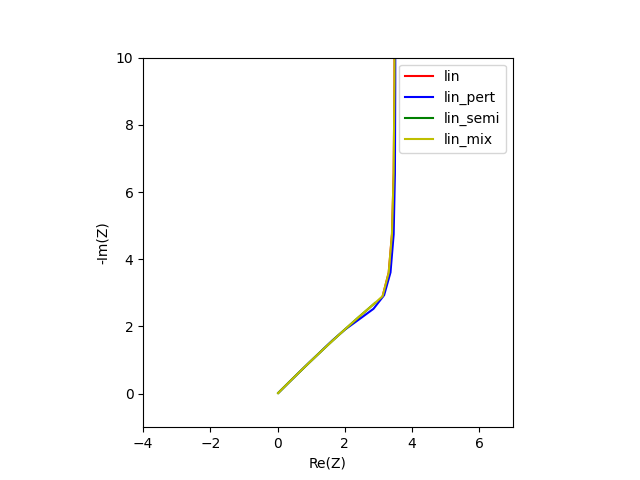

In [69]:
ax= plt.figure().add_subplot()
ax.plot(np.real(tlmlin_pred/(194.56/1.5)),-np.imag(tlmlin_pred/(194.56/1.5)),"r",label="lin")
ax.plot(np.real(tlmlin_zert_pred/(194.56/1.5)),-np.imag(tlmlin_zert_pred/(194.56/1.5)),"b",label="lin_pert")
ax.plot(np.real(tlmlin_semi_pred)/(194.56/1.5),-np.imag(tlmlin_semi_pred)/(194.56/1.5),"g",label="lin_semi")
ax.plot(np.real(tlmlin_mix_pred)/(194.56/1.5),-np.imag(tlmlin_mix_pred)/(194.56/1.5),"y",label="lin_mix")
ax.legend()
ax.set_xlabel("Re(Z)")
ax.set_ylabel("-Im(Z)")
ax.set_aspect("equal")
ax.set_xlim(-4,7)
ax.set_ylim(-1,10)

In [70]:
#fitted_lin_on_lin=tlmlin_guess.fit(f_pred,tlmlin_pred,weight_by_modulus=False)
#print(fitted_lin_on_lin)